---
# <center> **INSURANCE RISK CONTROL WITH REINSURANCE** </center>

----
# <center> **PYTHON IMPLEMENTATION OF JUMP-DIFFUSION HJB-PINN ALGORITHM** </center>

# <center> AMS516 PROJECT WORK </center>


---

> ## Author 1: Amos Anderson (116529628)
> ## Author 2: Indu Sai Atla    (116473189)

---

---

# **EXPERIMENTS**

---

We run three experiments, designed to isolate the effect of each modeling component and yields interpretable comparative statics:
* **Experiment 1: Impact of Claim Size Distribution** \
  We consider three main claim distributions namely; exponential (which is the baseline), pareto and log normal.

* **Experiment 2: Effect of Reinsurance Structure** \
  To compare how different reinsurance contract designs (proportional vs excess-of-loss) affect the optimal investment and reinsurance policies and the
  nsurer’s value function, under the same claim distribution and market environment.
  
* **Experiment 3: Parameter Sensitivity**\
    We analyze the sensitivity of optimal policies to model parameters.


---

## **Experiment 1: Impact of Claim Distribution On Optimal Investment-Reinsurance Policies**

----

### **Experiment 1A: Exponential Claims**

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# ============================================================
#    Global settings and parameters for Experiment 1A
#    Exponential claims, proportional reinsurance
# ============================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(123)

# Model / PDE parameters
T = 1.0
x_min, x_max = 0.0, 10.0

r = 0.03
mu = 0.08
sigma = 0.20
lambd = 1.0

# Loss weights
w_pde = 1.0
w_T = 10.0
w_BC = 1.0

eta_pi = 1e-6
eta_theta = 1e-4

# Collocation sizes
N_int = 5000 
N_T = 200
N_BC = 200

# ============================================================
#   Utility function, Claim Distribution PDF setup
# ============================================================

def U(x):
    # Exponential utility U(x) = -exp(-x)
    return -torch.exp(-x)

# Exponential claims Z ~ Exp(beta)
beta = 1.0

def fZ(z):
    # PDF of Z ~ Exp(beta)
    return beta * torch.exp(-beta * z)

In [6]:
# ============================================================
#   Setting up Gaussian Quadrature Configuration
# ============================================================

def gauss_legendre_quadrature(K=20, z_max=10.0):
    """
    Gauss-Legendre quadrature nodes/weights on [0, z_max].
    Approximate integrals of the form int_0^{z_max} g(z) dz.
    """
    xi, wi = np.polynomial.legendre.leggauss(K)
    z_k = 0.5 * (xi + 1.0) * z_max
    w_k = 0.5 * z_max * wi
    z_k = torch.tensor(z_k, dtype=torch.float32, device=device)
    w_k = torch.tensor(w_k, dtype=torch.float32, device=device)
    return z_k, w_k

# Quadrature config
K_quad = 32 
z_max = 10.0  # truncation level
z_k, w_k = gauss_legendre_quadrature(K=K_quad, z_max=z_max)

In [7]:
# ============================================================
#   PINN architecture: Forward Propagation
# ============================================================

class HJBPINN(nn.Module):
    def __init__(self, layers=[2, 64, 64, 64, 64, 3]):
        super().__init__()
        self.depth = len(layers)
        self.activation = nn.Tanh()

        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, t, x):
        """
        t, x: (N,1) tensors with requires_grad=True
        Output: V, pi, theta: (N,1)
        """
        inp = torch.cat((t, x), dim=1)
        z = inp
        for i in range(self.depth - 2):
            z = self.activation(self.layers[i](z))
        out = self.layers[-1](z)

        V_raw  = out[:, 0:1]
        pi_raw = out[:, 1:2]
        th_raw = out[:, 2:3]

        V = V_raw
        pi = pi_raw
        theta = torch.sigmoid(th_raw)  # in (0,1)

        return V, pi, theta

In [8]:
# ============================================================
#   Quadrature module: E[V(t, x - (1-theta) Z)]
# ============================================================

def jump_expectation(model, t, x, theta):
    """
    Approximate E[V(t, x - (1-theta)*Z)] using Gaussian quadrature:
    E_hat = sum_k w_k * V(t, x - (1-theta)*z_k) * fZ(z_k)
    """
    N = x.shape[0]
    K = z_k.shape[0]

    z = z_k.view(K, 1, 1)
    w = w_k.view(K, 1, 1)
    fz = fZ(z)

    x_b = x.view(1, N, 1)
    theta_b = theta.view(1, N, 1)

    x_shift = x_b - (1.0 - theta_b) * z

    t_flat = t.view(1, N, 1).expand(K, N, 1).reshape(K*N, 1)
    x_flat = x_shift.reshape(K*N, 1)

    V_flat, _, _ = model(t_flat, x_flat)
    V_vals = V_flat.view(K, N, 1)

    E_hat = torch.sum(w * fz * V_vals, dim=0)
    return E_hat

In [9]:
# ============================================================
#   HJB residual R_{\theta}(t,x)
# ============================================================

def hjb_residual(model, t, x):
    t.requires_grad_(True)
    x.requires_grad_(True)

    V, pi, theta = model(t, x)
    ones = torch.ones_like(V)

    V_t = torch.autograd.grad(V, t, grad_outputs=ones, create_graph=True)[0]
    V_x = torch.autograd.grad(V, x, grad_outputs=ones, create_graph=True)[0]
    V_xx = torch.autograd.grad(V_x, x, grad_outputs=ones, create_graph=True)[0]

    E_hat = jump_expectation(model, t, x, theta)

    drift = (r * x + pi * (mu - r)) * V_x
    diffusion = 0.5 * sigma**2 * (pi**2) * V_xx
    jump = lambd * (E_hat - V)

    R = V_t + drift + diffusion + jump
    return R, V, pi, theta

In [10]:
# ============================================================
#   Computing PINN Loss components:
#   Interior, Terminal, Boundary Condition, Regularization
# ============================================================

def loss_pde(R):
    return torch.mean(R**2)

def loss_terminal(model, N_T=200):
    x_T = torch.rand(N_T, 1, device=device) * (x_max - x_min) + x_min
    t_T = torch.full_like(x_T, T, device=device)
    V_T, _, _ = model(t_T, x_T)
    return torch.mean((V_T - U(x_T))**2)

def loss_boundary(model, N_BC=200):
    t_L = torch.rand(N_BC, 1, device=device) * T
    x_L = torch.full_like(t_L, x_min)
    V_L, _, _ = model(t_L, x_L)
    B_L = U(x_L)

    t_R = torch.rand(N_BC, 1, device=device) * T
    x_R = torch.full_like(t_R, x_max)
    x_eff = x_max * torch.exp(r * (T - t_R))
    B_R = U(x_eff)
    V_R, _, _ = model(t_R, x_R)

    return torch.mean((V_L - B_L)**2 + (V_R - B_R)**2)

def loss_reg(pi, theta):
    return eta_pi * torch.mean(pi**2) + eta_theta * torch.mean((theta - 0.5)**2)

In [21]:
def sample_interior(N_int):
    t = torch.rand(N_int, 1, device=device) * T
    x = torch.rand(N_int, 1, device=device) * (x_max - x_min) + x_min
    return t, x

def train_experiment_1A(num_epochs=3000, print_every=100):

    model = HJBPINN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    batch_size = 500
    loss_history = []

    for epoch in range(1, num_epochs + 1):

        total_loss_epoch = 0.0
        num_batches = N_int // batch_size

        for _ in range(num_batches):
            t_int, x_int = sample_interior(batch_size)

            R, V_int, pi_int, th_int = hjb_residual(model, t_int, x_int)
            L_pde = loss_pde(R)
            L_T = loss_terminal(model, N_T)
            L_BC = loss_boundary(model, N_BC)
            L_reg = loss_reg(pi_int, th_int)

            total_loss = w_pde * L_pde + w_T * L_T + w_BC * L_BC + L_reg

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            total_loss_epoch += total_loss.item()

        avg_loss = total_loss_epoch / num_batches
        loss_history.append(avg_loss)

        if epoch % print_every == 0:
            print(f"Epoch {epoch:5d} | Avg Loss: {avg_loss:.4e}")

    return model, loss_history

In [22]:
model_1A, loss_hist_1A = train_experiment_1A(num_epochs=3000, print_every=100)

Epoch   100 | Avg Loss: 3.5045e-04
Epoch   200 | Avg Loss: 4.6789e-05
Epoch   300 | Avg Loss: 1.1068e-04
Epoch   400 | Avg Loss: 4.1500e-05
Epoch   500 | Avg Loss: 2.3367e-05
Epoch   600 | Avg Loss: 1.3021e-05
Epoch   700 | Avg Loss: 1.9349e-05
Epoch   800 | Avg Loss: 3.2942e-04
Epoch   900 | Avg Loss: 7.1364e-06
Epoch  1000 | Avg Loss: 6.7285e-06
Epoch  1100 | Avg Loss: 7.8631e-06
Epoch  1200 | Avg Loss: 5.1827e-06
Epoch  1300 | Avg Loss: 5.1205e-06
Epoch  1400 | Avg Loss: 6.4037e-06
Epoch  1500 | Avg Loss: 2.0868e-05
Epoch  1600 | Avg Loss: 1.7301e-05
Epoch  1700 | Avg Loss: 4.7590e-06
Epoch  1800 | Avg Loss: 2.3956e-02
Epoch  1900 | Avg Loss: 5.2231e-06
Epoch  2000 | Avg Loss: 3.8071e-06
Epoch  2100 | Avg Loss: 3.3564e-06
Epoch  2200 | Avg Loss: 3.6429e-06
Epoch  2300 | Avg Loss: 5.4987e-05
Epoch  2400 | Avg Loss: 3.5451e-06
Epoch  2500 | Avg Loss: 8.1103e-06
Epoch  2600 | Avg Loss: 4.1250e-06
Epoch  2700 | Avg Loss: 2.9613e-06
Epoch  2800 | Avg Loss: 2.2995e-06
Epoch  2900 | Avg Lo

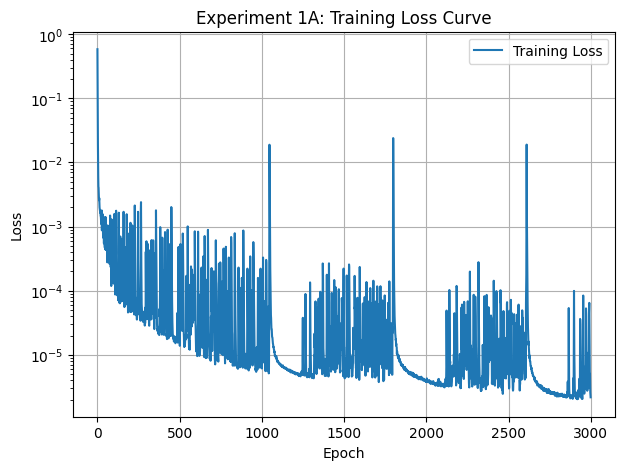

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(loss_hist_1A, label="Training Loss")
plt.yscale("log")  
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Experiment 1A: Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

----

#### Generating Surface Plots for $V(t,x), \pi(t,x)$ and $\theta(t,x)$

---

In [24]:
import torch
import numpy as np

def evaluate_model_on_grid(model, t_points=50, x_points=50):
    t_vals = np.linspace(0.0, T, t_points)
    x_vals = np.linspace(x_min, x_max, x_points)

    T_grid, X_grid = np.meshgrid(t_vals, x_vals, indexing="ij")

    t_tensor = torch.tensor(T_grid.reshape(-1,1), dtype=torch.float32, device=device)
    x_tensor = torch.tensor(X_grid.reshape(-1,1), dtype=torch.float32, device=device)

    with torch.no_grad():
        V, pi, theta = model(t_tensor, x_tensor)

    V = V.cpu().numpy().reshape(t_points, x_points)
    pi = pi.cpu().numpy().reshape(t_points, x_points)
    theta = theta.cpu().numpy().reshape(t_points, x_points)

    return t_vals, x_vals, V, pi, theta

In [25]:
import matplotlib.pyplot as plt

def plot_surface(t_vals, x_vals, Z, title, cmap="viridis"):
    T_grid, X_grid = np.meshgrid(t_vals, x_vals, indexing="ij")
    plt.figure(figsize=(6,5))
    plt.contourf(T_grid, X_grid, Z, 40, cmap=cmap)
    plt.colorbar()
    plt.xlabel("t")
    plt.ylabel("x")
    plt.title(title)
    plt.show()

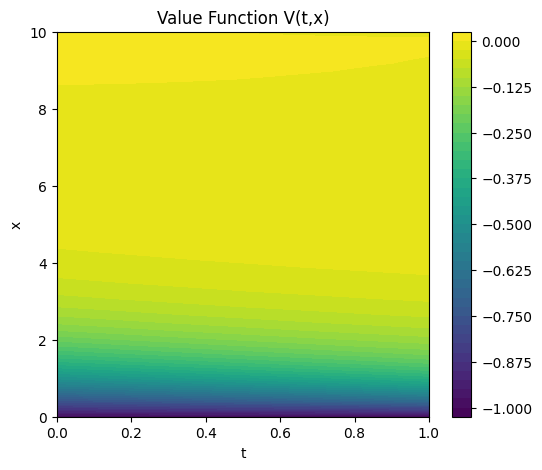

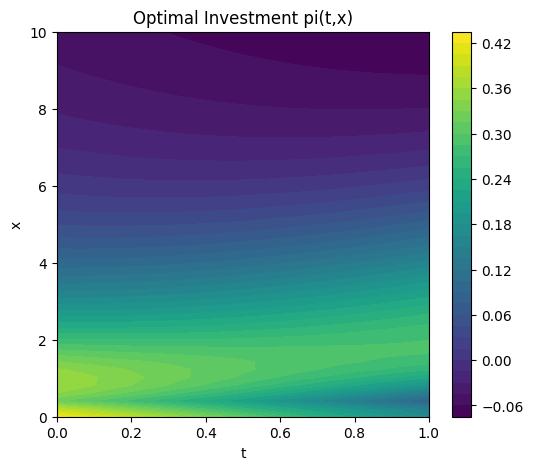

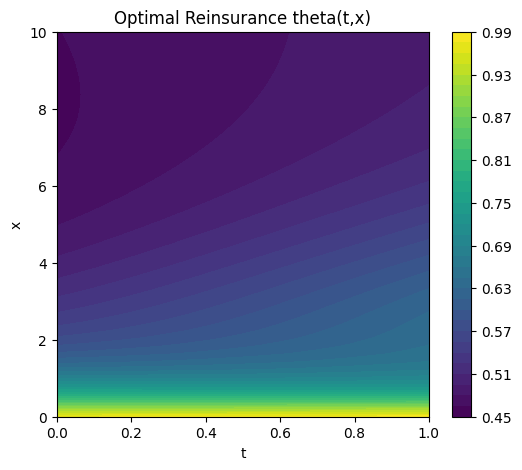

In [26]:
t_vals, x_vals, V_surf, pi_surf, theta_surf = evaluate_model_on_grid(model_1A)

plot_surface(t_vals, x_vals, V_surf, "Value Function V(t,x)")
plot_surface(t_vals, x_vals, pi_surf, "Optimal Investment pi(t,x)")
plot_surface(t_vals, x_vals, theta_surf, "Optimal Reinsurance theta(t,x)")

In [29]:
import plotly.graph_objects as go

def plot_3d_surface(t_vals, x_vals, Z, title):
    T_grid, X_grid = np.meshgrid(t_vals, x_vals, indexing="ij")

    fig = go.Figure(data=[
        go.Surface(
            x=T_grid,
            y=X_grid,
            z=Z,
            colorscale="Viridis",
            showscale=False
        )
    ])

    fig.update_layout(
        title=title,
        scene=dict(
            xaxis=dict(title="t"),
            yaxis=dict(title="x"),
            zaxis=dict(title=title)
        ),
        autosize=True,
        width=800,
        height=600
    )

    fig.show()

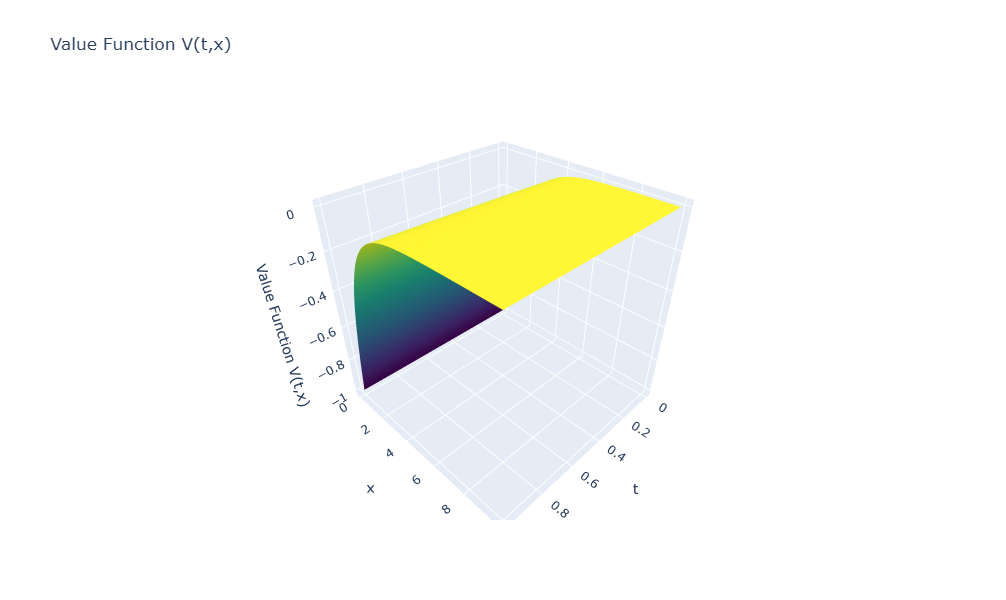

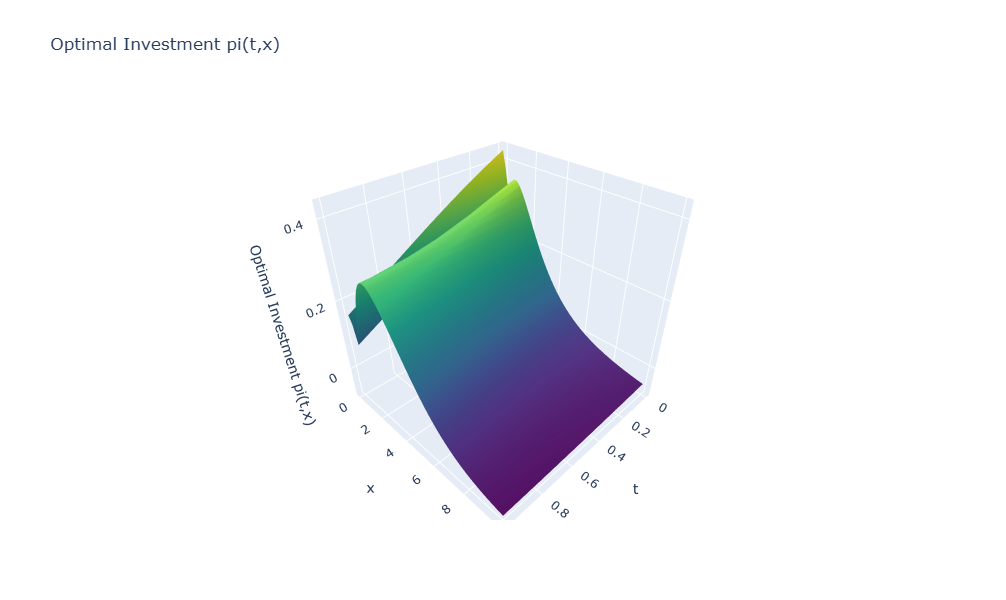

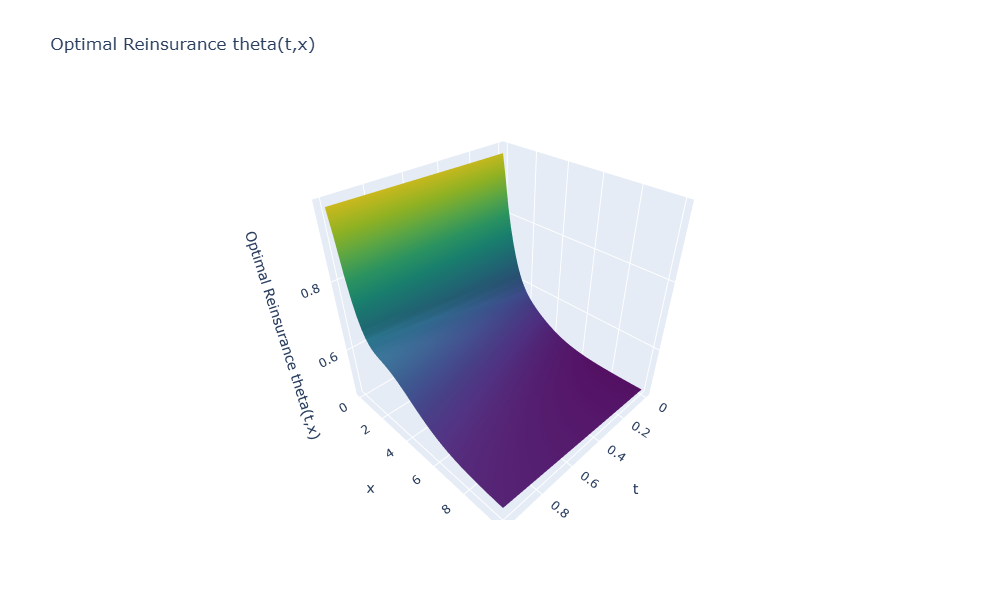

In [95]:
t_vals, x_vals, V_surf, pi_surf, theta_surf = evaluate_model_on_grid(model_1A)

plot_3d_surface(t_vals, x_vals, V_surf, "Value Function V(t,x)")
plot_3d_surface(t_vals, x_vals, pi_surf, "Optimal Investment pi(t,x)")
plot_3d_surface(t_vals, x_vals, theta_surf, "Optimal Reinsurance theta(t,x)")

### **Experiment 1B: Pareto Claims**

In [31]:
# ============================================================
#   Experiment 1B: Pareto Claim Distribution
# ============================================================

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

# Ensure same device setup as Experiment 1A
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(123)

# ============================================================
#   Global parameters (same as 1A)
# ============================================================

T = 1.0
x_min, x_max = 0.0, 10.0

r = 0.03
mu = 0.08
sigma = 0.20
lambd = 1.0

# Loss weights
w_pde = 1.0
w_T   = 10.0
w_BC  = 1.0

eta_pi    = 1e-6
eta_theta = 1e-4

# Collocation sizes
N_int = 5000
N_T   = 200
N_BC  = 200

In [32]:
# ============================================================
#   Utility function (same)
# ============================================================

def U(x):
    return -torch.exp(-x)

# ============================================================
#   Pareto Claim Distribution (Experiment 1B)
# ============================================================

alpha = 3.0
k = 1.0

def fZ(z):
    """Pareto PDF for z >= 0."""
    return (alpha * k**alpha) / ( (z + k)**(alpha + 1) )

In [33]:
# ============================================================
#   Gaussian Quadrature (same as 1A)
# ============================================================

def gauss_legendre_quadrature(K=32, z_max=10.0):
    xi, wi = np.polynomial.legendre.leggauss(K)
    z_k = 0.5 * (xi + 1.0) * z_max
    w_k = 0.5 * z_max * wi
    z_k = torch.tensor(z_k, dtype=torch.float32, device=device)
    w_k = torch.tensor(w_k, dtype=torch.float32, device=device)
    return z_k, w_k

K_quad = 32
z_max = 10.0
z_k, w_k = gauss_legendre_quadrature(K=K_quad, z_max=z_max)

In [34]:
# ============================================================
#   PINN Architecture (same as 1A)
# ============================================================

class HJBPINN(nn.Module):
    def __init__(self, layers=[2, 64, 64, 64, 64, 3]):
        super().__init__()
        self.depth = len(layers)
        self.activation = nn.Tanh()
        self.layers = nn.ModuleList()

        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, t, x):
        inp = torch.cat((t, x), dim=1)
        z = inp
        for i in range(self.depth - 2):
            z = self.activation(self.layers[i](z))
        out = self.layers[-1](z)

        V_raw  = out[:,0:1]
        pi_raw = out[:,1:2]
        th_raw = out[:,2:3]

        V = V_raw
        pi = pi_raw
        theta = torch.sigmoid(th_raw)
        return V, pi, theta

In [35]:
# ============================================================
#   Quadrature expectation E[V(t, x - (1-theta)Z)]
# ============================================================

def jump_expectation(model, t, x, theta):
    N = x.shape[0]
    K = z_k.shape[0]

    z  = z_k.view(K,1,1)
    w  = w_k.view(K,1,1)
    fz = fZ(z)

    x_b = x.view(1,N,1)
    theta_b = theta.view(1,N,1)

    x_shift = x_b - (1.0 - theta_b)*z

    t_flat = t.view(1,N,1).expand(K,N,1).reshape(K*N,1)
    x_flat = x_shift.reshape(K*N,1)

    V_flat, _, _ = model(t_flat, x_flat)
    V_vals = V_flat.view(K,N,1)

    E_hat = torch.sum(w * fz * V_vals, dim=0)
    return E_hat

In [36]:
# ============================================================
#   HJB Residual
# ============================================================

def hjb_residual(model, t, x):
    t.requires_grad_(True)
    x.requires_grad_(True)

    V, pi, theta = model(t,x)
    ones = torch.ones_like(V)

    V_t  = torch.autograd.grad(V, t, grad_outputs=ones, create_graph=True)[0]
    V_x  = torch.autograd.grad(V, x, grad_outputs=ones, create_graph=True)[0]
    V_xx = torch.autograd.grad(V_x, x, grad_outputs=ones, create_graph=True)[0]

    E_hat = jump_expectation(model, t, x, theta)

    drift = (r*x + pi*(mu-r)) * V_x
    diff  = 0.5 * sigma**2 * (pi**2) * V_xx
    jump  = lambd * (E_hat - V)

    R = V_t + drift + diff + jump
    return R, V, pi, theta

In [37]:
# ============================================================
#   Loss components
# ============================================================

def loss_pde(R):
    return torch.mean(R**2)

def loss_terminal(model, N_T):
    x_T = torch.rand(N_T,1,device=device)*(x_max-x_min) + x_min
    t_T = torch.full_like(x_T, T, device=device)
    V_T, _, _ = model(t_T, x_T)
    return torch.mean((V_T - U(x_T))**2)

def loss_boundary(model, N_BC):
    t_L = torch.rand(N_BC,1,device=device)*T
    x_L = torch.full_like(t_L, x_min)
    V_L, _, _ = model(t_L, x_L)
    B_L = U(x_L)

    t_R = torch.rand(N_BC,1,device=device)*T
    x_R = torch.full_like(t_R, x_max)
    x_eff = x_max * torch.exp(r*(T - t_R))
    B_R = U(x_eff)

    V_R, _, _ = model(t_R, x_R)
    return torch.mean((V_L - B_L)**2 + (V_R - B_R)**2)

def loss_reg(pi, theta):
    return eta_pi*torch.mean(pi**2) + eta_theta*torch.mean((theta-0.5)**2)

In [38]:
# ============================================================
#   Training Loop
# ============================================================

def sample_interior(N):
    t = torch.rand(N,1,device=device) * T
    x = torch.rand(N,1,device=device) * (x_max-x_min) + x_min
    return t, x

def train_experiment_1B(num_epochs=3000, print_every=100):

    model = HJBPINN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    loss_history = []

    for epoch in range(1, num_epochs+1):

        t_int, x_int = sample_interior(N_int)
        R, V_int, pi_int, th_int = hjb_residual(model, t_int, x_int)

        L_pde = loss_pde(R)
        L_T   = loss_terminal(model, N_T)
        L_BC  = loss_boundary(model, N_BC)
        L_reg = loss_reg(pi_int, th_int)

        total_loss = w_pde*L_pde + w_T*L_T + w_BC*L_BC + L_reg

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        loss_history.append(total_loss.item())

        if epoch % print_every == 0:
            print(f"Epoch {epoch:5d} | Loss: {total_loss.item():.4e}")

    return model, loss_history

In [39]:
# ======================= Run experiment =======================

model_1B, loss_hist_1B = train_experiment_1B()

Epoch   100 | Loss: 6.6953e-03
Epoch   200 | Loss: 2.9772e-03
Epoch   300 | Loss: 1.5194e-03
Epoch   400 | Loss: 1.0143e-03
Epoch   500 | Loss: 6.1672e-04
Epoch   600 | Loss: 5.0129e-04
Epoch   700 | Loss: 2.8382e-04
Epoch   800 | Loss: 2.3003e-04
Epoch   900 | Loss: 1.8293e-04
Epoch  1000 | Loss: 1.4636e-03
Epoch  1100 | Loss: 1.3306e-04
Epoch  1200 | Loss: 1.0113e-04
Epoch  1300 | Loss: 8.7747e-05
Epoch  1400 | Loss: 5.0813e-04
Epoch  1500 | Loss: 1.5476e-04
Epoch  1600 | Loss: 8.2456e-05
Epoch  1700 | Loss: 1.2987e-03
Epoch  1800 | Loss: 6.5470e-05
Epoch  1900 | Loss: 6.4030e-05
Epoch  2000 | Loss: 1.0431e-04
Epoch  2100 | Loss: 6.4051e-05
Epoch  2200 | Loss: 1.2802e-04
Epoch  2300 | Loss: 3.5976e-04
Epoch  2400 | Loss: 5.4274e-05
Epoch  2500 | Loss: 1.4793e-04
Epoch  2600 | Loss: 7.5076e-05
Epoch  2700 | Loss: 2.0597e-03
Epoch  2800 | Loss: 3.9853e-05
Epoch  2900 | Loss: 5.1766e-05
Epoch  3000 | Loss: 7.7838e-05


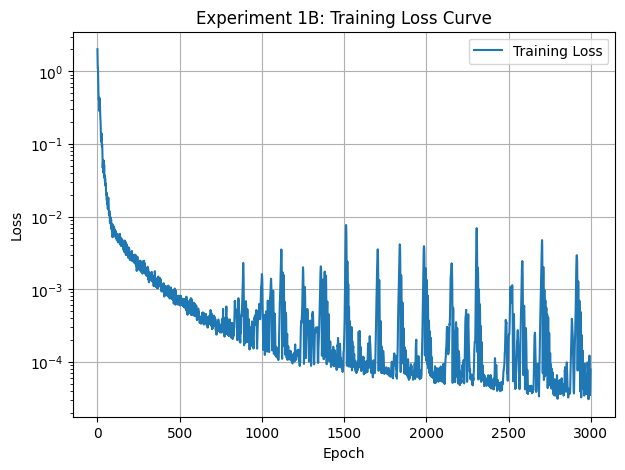

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(loss_hist_1B, label="Training Loss")
plt.yscale("log")  
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Experiment 1B: Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

#### Generating Surface Plots for $V(t,x), \pi(t,x)$ and $\theta(t,x)$

---

In [41]:
import torch
import numpy as np

def evaluate_model_on_grid(model, t_points=50, x_points=50):
    t_vals = np.linspace(0.0, T, t_points)
    x_vals = np.linspace(x_min, x_max, x_points)

    T_grid, X_grid = np.meshgrid(t_vals, x_vals, indexing="ij")

    t_tensor = torch.tensor(T_grid.reshape(-1,1), dtype=torch.float32, device=device)
    x_tensor = torch.tensor(X_grid.reshape(-1,1), dtype=torch.float32, device=device)

    with torch.no_grad():
        V, pi, theta = model(t_tensor, x_tensor)

    V = V.cpu().numpy().reshape(t_points, x_points)
    pi = pi.cpu().numpy().reshape(t_points, x_points)
    theta = theta.cpu().numpy().reshape(t_points, x_points)

    return t_vals, x_vals, V, pi, theta

In [47]:
t_vals_1B, x_vals_1B, V_surf_1B, pi_surf_1B, theta_surf_1B = evaluate_model_on_grid(model_1B)

plot_3d_surface(t_vals_1B, x_vals_1B, V_surf_1B, "Value Function V(t,x)")
plot_3d_surface(t_vals_1B, x_vals_1B, pi_surf_1B, "Optimal Investment pi(t,x)")
plot_3d_surface(t_vals_1B, x_vals_1B, theta_surf_1B, "Optimal Reinsurance theta(t,x)")

### **Experiment 1C: Log-normal Claims**

In [49]:
# ============================================================
#   Experiment 1C: Lognormal Claim Distribution
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(123)

# ------------------------------------------------------------
# Global parameters (same as 1A / 1B)
# ------------------------------------------------------------
T = 1.0
x_min, x_max = 0.0, 10.0

r = 0.03
mu = 0.08
sigma = 0.20
lambd = 1.0

w_pde = 1.0
w_T   = 10.0
w_BC  = 1.0

eta_pi    = 1e-6
eta_theta = 1e-4

N_int = 5000
N_T   = 200
N_BC  = 200

In [50]:
# ------------------------------------------------------------
# Utility
# ------------------------------------------------------------
def U(x):
    return -torch.exp(-x)

# ------------------------------------------------------------
# Lognormal Claim Distribution (Experiment 1C)
# ------------------------------------------------------------
mu_Z     = 0.0
sigma_Z  = 0.5

def fZ(z):
    """
    Lognormal PDF for z > 0, with parameters mu_Z, sigma_Z.
    z is a torch tensor.
    """
    # avoid log(0) if any tiny z appears
    eps = 1e-10
    z_safe = torch.clamp(z, min=eps)
    coeff = 1.0 / (z_safe * sigma_Z * np.sqrt(2.0 * np.pi))
    exponent = - (torch.log(z_safe) - mu_Z)**2 / (2.0 * sigma_Z**2)
    return coeff * torch.exp(exponent)

In [51]:
# ------------------------------------------------------------
# Gauss-Legendre quadrature on [0, z_max]
# ------------------------------------------------------------
def gauss_legendre_quadrature(K=32, z_max=15.0):
    xi, wi = np.polynomial.legendre.leggauss(K)
    z_k = 0.5 * (xi + 1.0) * z_max
    w_k = 0.5 * z_max * wi
    z_k = torch.tensor(z_k, dtype=torch.float32, device=device)
    w_k = torch.tensor(w_k, dtype=torch.float32, device=device)
    return z_k, w_k

K_quad = 32
z_max  = 15.0
z_k, w_k = gauss_legendre_quadrature(K=K_quad, z_max=z_max)

In [52]:
# ------------------------------------------------------------
# PINN architecture (same as 1A)
# ------------------------------------------------------------
class HJBPINN(nn.Module):
    def __init__(self, layers=[2, 64, 64, 64, 64, 3]):
        super().__init__()
        self.depth = len(layers)
        self.activation = nn.Tanh()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, t, x):
        inp = torch.cat((t, x), dim=1)
        z = inp
        for i in range(self.depth - 2):
            z = self.activation(self.layers[i](z))
        out = self.layers[-1](z)

        V_raw  = out[:, 0:1]
        pi_raw = out[:, 1:2]
        th_raw = out[:, 2:3]

        V = V_raw
        pi = pi_raw
        theta = torch.sigmoid(th_raw)
        return V, pi, theta

In [53]:
# ------------------------------------------------------------
# Jump expectation E[V(t, x - (1-theta) Z)]
# ------------------------------------------------------------
def jump_expectation(model, t, x, theta):
    N = x.shape[0]
    K = z_k.shape[0]

    z  = z_k.view(K, 1, 1)
    w  = w_k.view(K, 1, 1)
    fz = fZ(z)

    x_b     = x.view(1, N, 1)
    theta_b = theta.view(1, N, 1)

    x_shift = x_b - (1.0 - theta_b) * z

    t_flat = t.view(1, N, 1).expand(K, N, 1).reshape(K * N, 1)
    x_flat = x_shift.reshape(K * N, 1)

    V_flat, _, _ = model(t_flat, x_flat)
    V_vals = V_flat.view(K, N, 1)

    E_hat = torch.sum(w * fz * V_vals, dim=0)
    return E_hat

In [54]:
# ------------------------------------------------------------
# HJB residual
# ------------------------------------------------------------
def hjb_residual(model, t, x):
    t.requires_grad_(True)
    x.requires_grad_(True)

    V, pi, theta = model(t, x)
    ones = torch.ones_like(V)

    V_t  = torch.autograd.grad(V, t, grad_outputs=ones,
                               create_graph=True)[0]
    V_x  = torch.autograd.grad(V, x, grad_outputs=ones,
                               create_graph=True)[0]
    V_xx = torch.autograd.grad(V_x, x, grad_outputs=ones,
                               create_graph=True)[0]

    E_hat = jump_expectation(model, t, x, theta)

    drift = (r * x + pi * (mu - r)) * V_x
    diff  = 0.5 * sigma**2 * (pi**2) * V_xx
    jump  = lambd * (E_hat - V)

    R = V_t + drift + diff + jump
    return R, V, pi, theta

In [55]:
# ------------------------------------------------------------
# Loss components
# ------------------------------------------------------------
def loss_pde(R):
    return torch.mean(R**2)

def loss_terminal(model, N_T):
    x_T = torch.rand(N_T, 1, device=device) * (x_max - x_min) + x_min
    t_T = torch.full_like(x_T, T, device=device)
    V_T, _, _ = model(t_T, x_T)
    return torch.mean((V_T - U(x_T))**2)

def loss_boundary(model, N_BC):
    t_L = torch.rand(N_BC, 1, device=device) * T
    x_L = torch.full_like(t_L, x_min)
    V_L, _, _ = model(t_L, x_L)
    B_L = U(x_L)

    t_R = torch.rand(N_BC, 1, device=device) * T
    x_R = torch.full_like(t_R, x_max)
    x_eff = x_max * torch.exp(r * (T - t_R))
    B_R = U(x_eff)

    V_R, _, _ = model(t_R, x_R)
    return torch.mean((V_L - B_L)**2 + (V_R - B_R)**2)

def loss_reg(pi, theta):
    return eta_pi * torch.mean(pi**2) + eta_theta * torch.mean((theta - 0.5)**2)

In [56]:
# ------------------------------------------------------------
# Sampling and training loop (batched, like 1A)
# ------------------------------------------------------------
def sample_interior(N):
    t = torch.rand(N, 1, device=device) * T
    x = torch.rand(N, 1, device=device) * (x_max - x_min) + x_min
    return t, x

def train_experiment_1C(num_epochs=3000, print_every=100):

    model = HJBPINN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    batch_size = 500
    loss_history = []

    for epoch in range(1, num_epochs + 1):

        total_loss_epoch = 0.0
        num_batches = N_int // batch_size

        for _ in range(num_batches):
            t_int, x_int = sample_interior(batch_size)
            R, V_int, pi_int, th_int = hjb_residual(model, t_int, x_int)

            L_pde = loss_pde(R)
            L_T   = loss_terminal(model, N_T)
            L_BC  = loss_boundary(model, N_BC)
            L_reg = loss_reg(pi_int, th_int)

            total_loss = w_pde * L_pde + w_T * L_T + w_BC * L_BC + L_reg

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            total_loss_epoch += total_loss.item()

        avg_loss = total_loss_epoch / num_batches
        loss_history.append(avg_loss)

        if epoch % print_every == 0:
            print(f"Epoch {epoch:5d} | Avg Loss: {avg_loss:.4e}")

    return model, loss_history

In [57]:
# -------------------- run training ---------------------------

model_1C, loss_hist_1C = train_experiment_1C()

Epoch   100 | Avg Loss: 4.2626e-04
Epoch   200 | Avg Loss: 6.6697e-04
Epoch   300 | Avg Loss: 7.6427e-05
Epoch   400 | Avg Loss: 4.9339e-05
Epoch   500 | Avg Loss: 4.8095e-05
Epoch   600 | Avg Loss: 5.3372e-05
Epoch   700 | Avg Loss: 1.3315e-05
Epoch   800 | Avg Loss: 3.0026e-05
Epoch   900 | Avg Loss: 1.6299e-05
Epoch  1000 | Avg Loss: 1.6098e-05
Epoch  1100 | Avg Loss: 1.9201e-05
Epoch  1200 | Avg Loss: 9.3683e-06
Epoch  1300 | Avg Loss: 2.1710e-04
Epoch  1400 | Avg Loss: 9.9015e-06
Epoch  1500 | Avg Loss: 3.4031e-05
Epoch  1600 | Avg Loss: 3.6719e-05
Epoch  1700 | Avg Loss: 5.9100e-06
Epoch  1800 | Avg Loss: 4.5657e-06
Epoch  1900 | Avg Loss: 8.8009e-05
Epoch  2000 | Avg Loss: 1.7296e-05
Epoch  2100 | Avg Loss: 4.7746e-06
Epoch  2200 | Avg Loss: 8.7732e-06
Epoch  2300 | Avg Loss: 5.7473e-06
Epoch  2400 | Avg Loss: 1.3443e-05
Epoch  2500 | Avg Loss: 4.8370e-06
Epoch  2600 | Avg Loss: 4.8545e-03
Epoch  2700 | Avg Loss: 2.6799e-06
Epoch  2800 | Avg Loss: 1.1435e-05
Epoch  2900 | Avg Lo

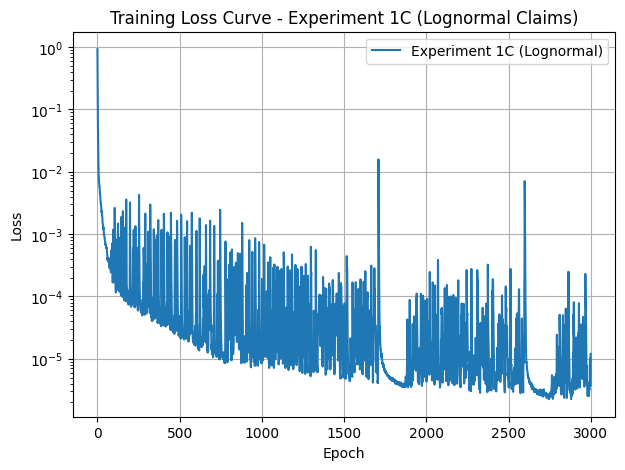

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(loss_hist_1C, label="Experiment 1C (Lognormal)")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve - Experiment 1C (Lognormal Claims)")
plt.legend()
plt.grid(True)
plt.show()

#### Generating Surface Plots for $V(t,x), \pi(t,x)$ and $\theta(t,x)$

---

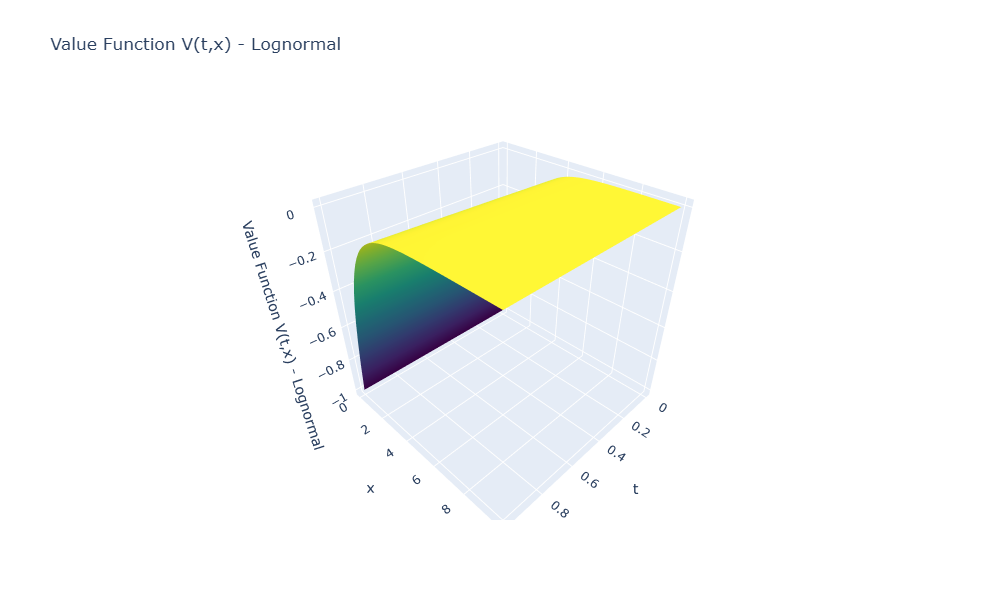

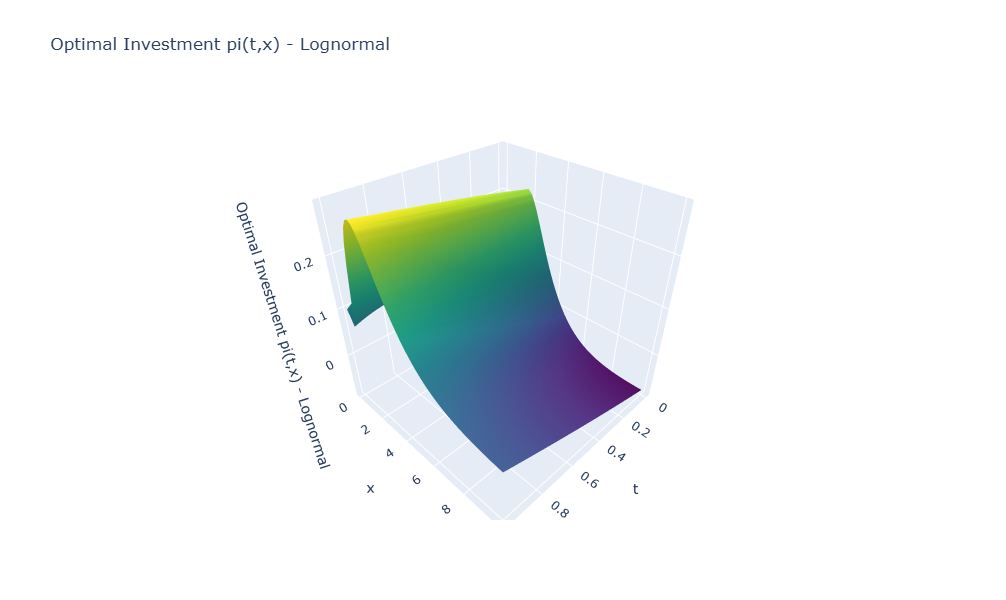

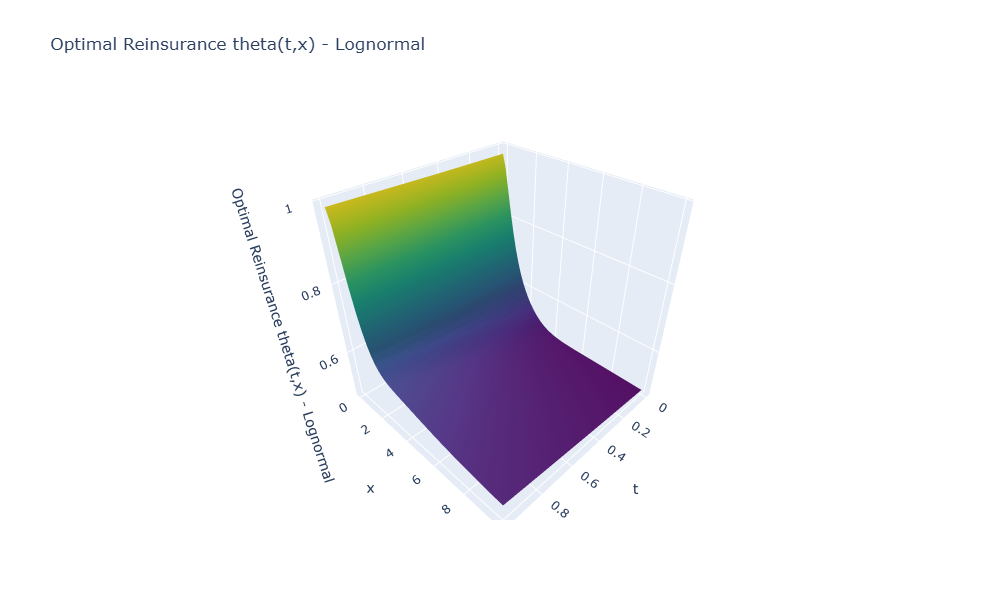

In [59]:
t_vals, x_vals, V_surf_1C, pi_surf_1C, theta_surf_1C = evaluate_model_on_grid(model_1C)

plot_3d_surface(t_vals, x_vals, V_surf_1C, "Value Function V(t,x) - Lognormal")
plot_3d_surface(t_vals, x_vals, pi_surf_1C, "Optimal Investment pi(t,x) - Lognormal")
plot_3d_surface(t_vals, x_vals, theta_surf_1C, "Optimal Reinsurance theta(t,x) - Lognormal")

### **Comparison Table For Experiment 1A, 1B and 1C**

We now construct the comparison table for Experiment 1A, 1B, and 1C at the point: $$(t_0,x_0) = (0.5,5)$$

In [62]:
t0 = torch.tensor([[0.5]], dtype=torch.float32, device=device)
x0 = torch.tensor([[5.0]], dtype=torch.float32, device=device)

def evaluate_point(model, name="Model"):
    with torch.no_grad():
        V, pi, theta = model(t0, x0)
    print(f"{name}:")
    print(" V(t0,x0)     =", float(V.item()))
    print(" pi(t0,x0)    =", float(pi.item()))
    print(" theta(t0,x0) =", float(theta.item()))
    print()

evaluate_point(model_1A, "Experiment 1A (Exponential)")
evaluate_point(model_1B, "Experiment 1B (Pareto)")
evaluate_point(model_1C, "Experiment 1C (Lognormal)")

Experiment 1A (Exponential):
 V(t0,x0)     = -0.009542286396026611
 pi(t0,x0)    = 0.048989858478307724
 theta(t0,x0) = 0.5126673579216003

Experiment 1B (Pareto):
 V(t0,x0)     = -0.01002926379442215
 pi(t0,x0)    = 0.8065438866615295
 theta(t0,x0) = 0.7479036450386047

Experiment 1C (Lognormal):
 V(t0,x0)     = -0.008478423580527306
 pi(t0,x0)    = 0.026354992762207985
 theta(t0,x0) = 0.5097519755363464



----
## **Experiment 2: Impact of Reinsurance Structure on Optimal Policies**

---

### **Experiment 2A: Proportional Reinsurance**

This is basically what we run for Experiment 1A.

### **Experiment 2B: Excess-of-Loss Reinsurance**

In [64]:
# ============================================================
#   Experiment 2B: Excess-of-Loss Reinsurance
# ============================================================

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(123)

# ------------------------------------------------------------
# Global parameters (same as Experiment 1A/2A)
# ------------------------------------------------------------
T = 1.0
x_min, x_max = 0.0, 10.0

r = 0.03
mu = 0.08
sigma = 0.20
lambd = 1.0

# Loss weights
w_pde = 1.0
w_T   = 10.0
w_BC  = 1.0

eta_pi    = 1e-6
eta_M     = 1e-4   # regularization for M

# Collocation sizes
N_int = 5000
N_T   = 200
N_BC  = 200

In [65]:
# ------------------------------------------------------------
# Utility
# ------------------------------------------------------------
def U(x):
    return -torch.exp(-x)

# ------------------------------------------------------------
# Claim distribution: Exponential (same as Experiment 1A)
# ------------------------------------------------------------
beta = 1.0

def fZ(z):
    return beta * torch.exp(-beta * z)

In [66]:
# ------------------------------------------------------------
# Quadrature for jump expectation
# ------------------------------------------------------------
def gauss_legendre_quadrature(K=32, z_max=10.0):
    xi, wi = np.polynomial.legendre.leggauss(K)
    z_k = 0.5 * (xi + 1.0) * z_max
    w_k = 0.5 * z_max * wi
    z_k = torch.tensor(z_k, dtype=torch.float32, device=device)
    w_k = torch.tensor(w_k, dtype=torch.float32, device=device)
    return z_k, w_k

K_quad = 32
z_max  = 10.0
z_k, w_k = gauss_legendre_quadrature(K=K_quad, z_max=z_max)

In [67]:
# ------------------------------------------------------------
# PINN Architecture for Excess-of-Loss:
# Outputs: V_raw, pi_raw, M_raw
# ------------------------------------------------------------
M_max = 10.0  # deductible/retention upper bound

class HJBPINN_XoL(nn.Module):
    def __init__(self, layers=[2,64,64,64,64,3]):
        super().__init__()
        self.depth = len(layers)
        self.activation = nn.Tanh()
        self.layers = nn.ModuleList()

        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))

    def forward(self, t, x):
        inp = torch.cat((t, x), dim=1)
        z = inp

        for i in range(self.depth - 2):
            z = self.activation(self.layers[i](z))

        out = self.layers[-1](z)

        V_raw  = out[:,0:1]
        pi_raw = out[:,1:2]
        M_raw  = out[:,2:3]

        # Transform M into (0, M_max)
        M = M_max * torch.sigmoid(M_raw)

        V  = V_raw
        pi = pi_raw

        return V, pi, M

In [68]:
# ------------------------------------------------------------
# Jump expectation: x - min(Z, M)
# ------------------------------------------------------------
def jump_expectation_XoL(model, t, x, M):
    N = x.shape[0]
    K = z_k.shape[0]

    z  = z_k.view(K,1,1)
    w  = w_k.view(K,1,1)
    fz = fZ(z)

    x_b = x.view(1,N,1)
    M_b = M.view(1,N,1)

    retained = torch.minimum(z, M_b)          # Z ∧ M
    x_shift  = x_b - retained

    t_flat = t.view(1,N,1).expand(K,N,1).reshape(K*N,1)
    x_flat = x_shift.reshape(K*N,1)

    V_flat, _, _ = model(t_flat, x_flat)
    V_vals = V_flat.view(K,N,1)

    E_hat = torch.sum(w * fz * V_vals, dim=0)
    return E_hat

In [69]:
# ------------------------------------------------------------
# HJB Residual for Excess-of-Loss
# ------------------------------------------------------------
def hjb_residual_XoL(model, t, x):
    t.requires_grad_(True)
    x.requires_grad_(True)

    V, pi, M = model(t, x)
    ones = torch.ones_like(V)

    V_t  = torch.autograd.grad(V, t, grad_outputs=ones, create_graph=True)[0]
    V_x  = torch.autograd.grad(V, x, grad_outputs=ones, create_graph=True)[0]
    V_xx = torch.autograd.grad(V_x, x, grad_outputs=ones, create_graph=True)[0]

    E_hat = jump_expectation_XoL(model, t, x, M)

    drift = (r*x + pi*(mu - r)) * V_x
    diff  = 0.5 * sigma**2 * (pi**2) * V_xx
    jump  = lambd * (E_hat - V)

    R = V_t + drift + diff + jump
    return R, V, pi, M

In [70]:
# ------------------------------------------------------------
# Loss terms
# ------------------------------------------------------------
def loss_pde(R):
    return torch.mean(R**2)

def loss_terminal(model, N_T):
    x_T = torch.rand(N_T,1,device=device)*(x_max-x_min) + x_min
    t_T = torch.full_like(x_T, T, device=device)
    V_T, _, _ = model(t_T, x_T)
    return torch.mean((V_T - U(x_T))**2)

def loss_boundary(model, N_BC):
    t_L = torch.rand(N_BC,1,device=device)*T
    x_L = torch.full_like(t_L, x_min)
    V_L, _, _ = model(t_L, x_L)
    B_L = U(x_L)

    t_R = torch.rand(N_BC,1,device=device)*T
    x_R = torch.full_like(t_R, x_max)
    x_eff = x_max * torch.exp(r*(T - t_R))
    B_R = U(x_eff)
    V_R, _, _ = model(t_R, x_R)

    return torch.mean((V_L - B_L)**2 + (V_R - B_R)**2)

def loss_reg(pi, M):
    # Encourage reasonable control magnitudes
    M_target = M_max / 2  # stabilizer
    return eta_pi*torch.mean(pi**2) + eta_M*torch.mean((M - M_target)**2)

In [71]:
# ------------------------------------------------------------
# Sampling + Training Loop
# ------------------------------------------------------------
def sample_interior(N):
    t = torch.rand(N,1,device=device)*T
    x = torch.rand(N,1,device=device)*(x_max-x_min) + x_min
    return t, x

def train_experiment_2B(num_epochs=3000, print_every=100):
    model = HJBPINN_XoL().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    batch_size = 500
    loss_history = []

    for epoch in range(1, num_epochs+1):
        total_loss_epoch = 0.0
        num_batches = N_int // batch_size

        for _ in range(num_batches):
            t_int, x_int = sample_interior(batch_size)
            R, V_int, pi_int, M_int = hjb_residual_XoL(model, t_int, x_int)

            L_pde = loss_pde(R)
            L_T   = loss_terminal(model, N_T)
            L_BC  = loss_boundary(model, N_BC)
            L_reg = loss_reg(pi_int, M_int)

            total_loss = w_pde*L_pde + w_T*L_T + w_BC*L_BC + L_reg

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            total_loss_epoch += total_loss.item()

        avg_loss = total_loss_epoch / num_batches
        loss_history.append(avg_loss)

        if epoch % print_every == 0:
            print(f"Epoch {epoch:5d} | Avg Loss: {avg_loss:.4e}")

    return model, loss_history

In [72]:
# ---------------------- Run training -------------------------

model_2B, loss_hist_2B = train_experiment_2B()

Epoch   100 | Avg Loss: 1.4306e-03
Epoch   200 | Avg Loss: 3.8014e-04
Epoch   300 | Avg Loss: 8.2590e-05
Epoch   400 | Avg Loss: 8.0957e-05
Epoch   500 | Avg Loss: 2.5005e-05
Epoch   600 | Avg Loss: 1.4826e-05
Epoch   700 | Avg Loss: 1.2904e-05
Epoch   800 | Avg Loss: 1.0595e-05
Epoch   900 | Avg Loss: 1.6979e-05
Epoch  1000 | Avg Loss: 6.3866e-06
Epoch  1100 | Avg Loss: 1.0523e-04
Epoch  1200 | Avg Loss: 2.1230e-05
Epoch  1300 | Avg Loss: 1.6302e-05
Epoch  1400 | Avg Loss: 6.7869e-06
Epoch  1500 | Avg Loss: 5.8988e-06
Epoch  1600 | Avg Loss: 9.7594e-06
Epoch  1700 | Avg Loss: 6.4672e-06
Epoch  1800 | Avg Loss: 2.8291e-04
Epoch  1900 | Avg Loss: 3.4124e-05
Epoch  2000 | Avg Loss: 1.4478e-05
Epoch  2100 | Avg Loss: 2.0487e-06
Epoch  2200 | Avg Loss: 7.0149e-06
Epoch  2300 | Avg Loss: 2.9171e-05
Epoch  2400 | Avg Loss: 1.6126e-06
Epoch  2500 | Avg Loss: 1.2302e-06
Epoch  2600 | Avg Loss: 1.5615e-06
Epoch  2700 | Avg Loss: 1.4648e-05
Epoch  2800 | Avg Loss: 2.8430e-06
Epoch  2900 | Avg Lo

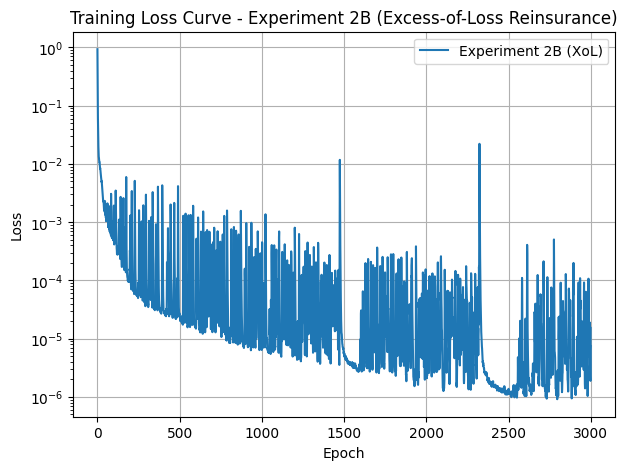

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.plot(loss_hist_2B, label="Experiment 2B (XoL)")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve - Experiment 2B (Excess-of-Loss Reinsurance)")
plt.legend()
plt.grid(True)
plt.show()

#### Generating Surface Plots for $V(t,x), \pi(t,x)$ and $M(t,x)$

---

In [79]:
import torch
import numpy as np

def evaluate_model_on_grid(model, t_points=50, x_points=50):
    t_vals = np.linspace(0.0, T, t_points)
    x_vals = np.linspace(x_min, x_max, x_points)

    T_grid, X_grid = np.meshgrid(t_vals, x_vals, indexing="ij")

    t_tensor = torch.tensor(T_grid.reshape(-1,1), dtype=torch.float32, device=device)
    x_tensor = torch.tensor(X_grid.reshape(-1,1), dtype=torch.float32, device=device)

    with torch.no_grad():
        V, pi, m = model(t_tensor, x_tensor)

    V = V.cpu().numpy().reshape(t_points, x_points)
    pi = pi.cpu().numpy().reshape(t_points, x_points)
    m = m.cpu().numpy().reshape(t_points, x_points)

    return t_vals, x_vals, V, pi, m

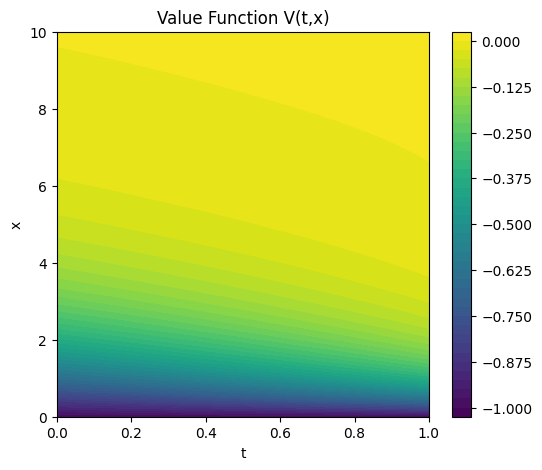

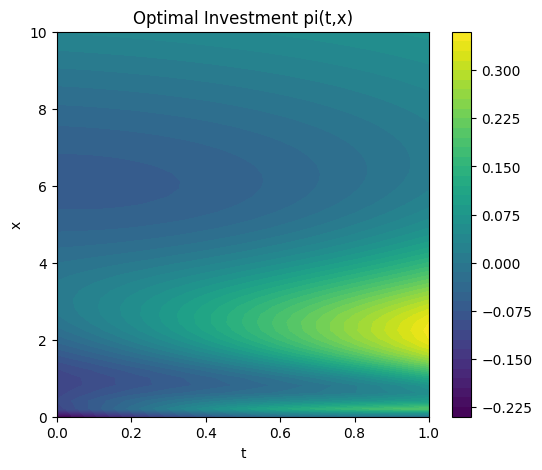

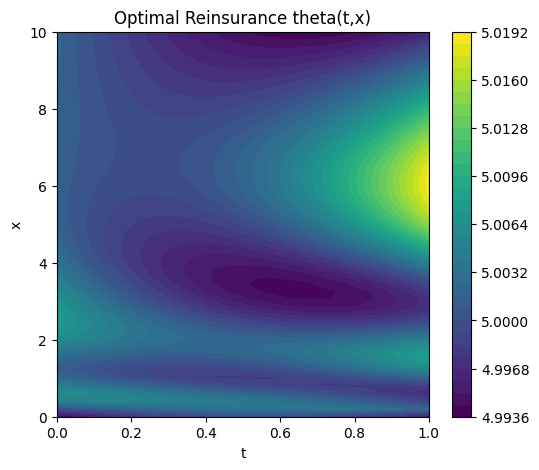

In [81]:
t_vals, x_vals, V_surf_2B, pi_surf_2B, m_surf = evaluate_model_on_grid(model_2B)

plot_surface(t_vals, x_vals, V_surf_2B, "Value Function V(t,x)")
plot_surface(t_vals, x_vals, pi_surf_2B, "Optimal Investment pi(t,x)")
plot_surface(t_vals, x_vals, m_surf, "Optimal Reinsurance theta(t,x)")

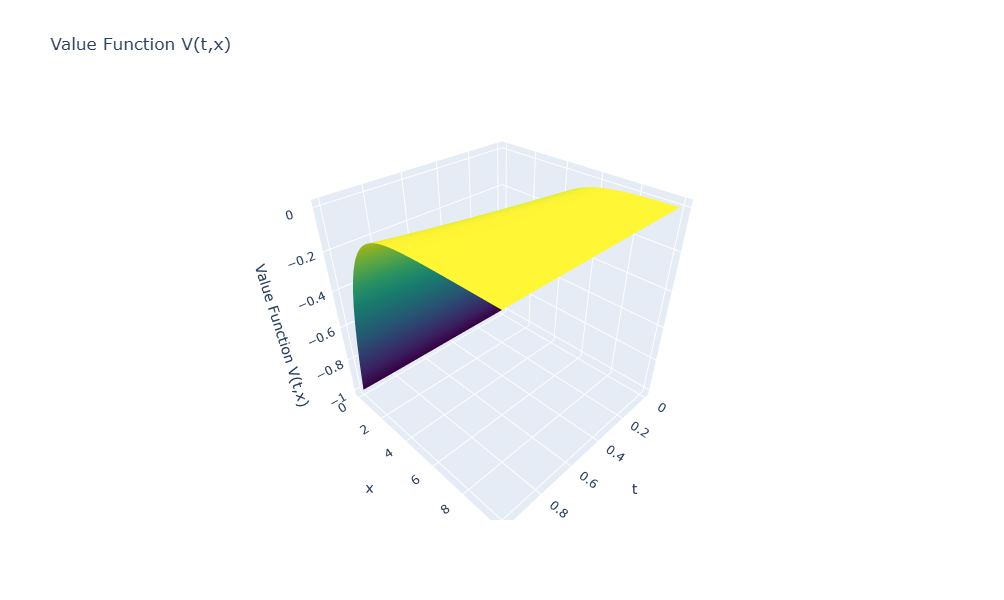

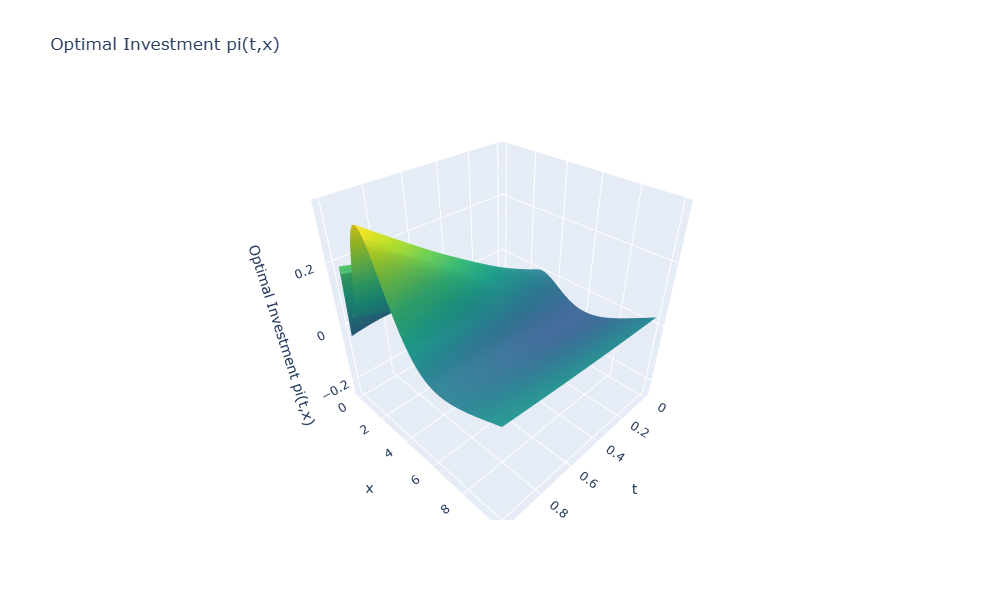

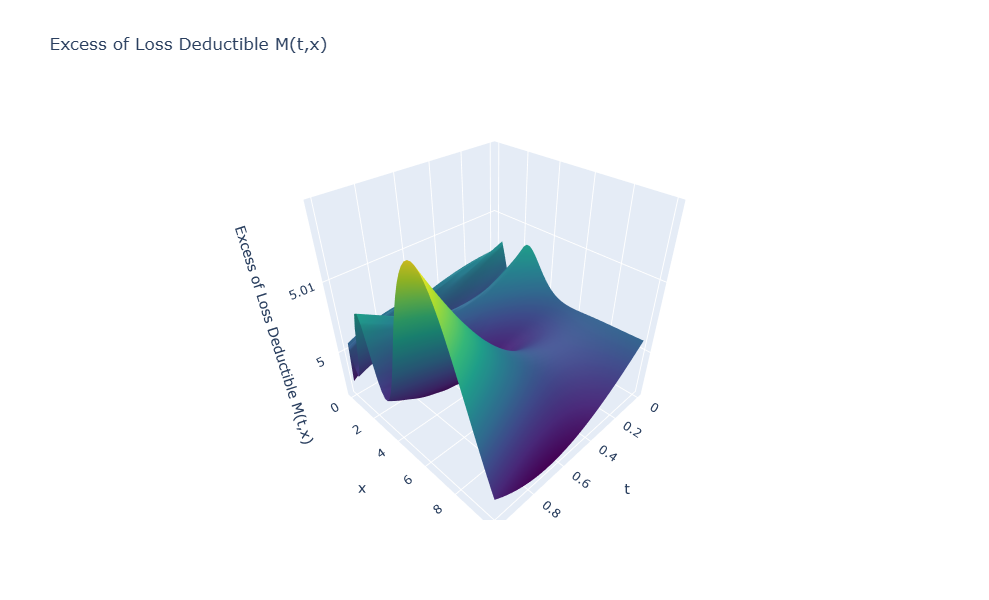

In [94]:
t_vals, x_vals, V_surf_2B, pi_surf_2B, m_surf = evaluate_model_on_grid(model_2B)

plot_3d_surface(t_vals, x_vals, V_surf_2B, "Value Function V(t,x)")
plot_3d_surface(t_vals, x_vals, pi_surf_2B, "Optimal Investment pi(t,x)")
plot_3d_surface(t_vals, x_vals, m_surf, "Excess of Loss Deductible M(t,x)")

## **Comparing Proportional and Excess of Loss Reinsurance at a point**

We compute Experiment 2B at the point $$(t_0,x_0) = (0.5, 5)$$ as we did in Experiment 2A and Experiment 1A.

In [92]:
t0 = torch.tensor([[0.5]], dtype=torch.float32, device=device)
x0 = torch.tensor([[5.0]], dtype=torch.float32, device=device)

def evaluate_point(model, name="Model"):
    with torch.no_grad():
        V, pi, c = model(t0, x0)
    print(f"{name}:")
    print(" V(t0,x0)     =", float(V.item()))
    print(" pi(t0,x0)    =", float(pi.item()))
    print(" M(t0,x0)     =", float(c.item()))
    print()

evaluate_point(model_2B, "Experiment 2B (XoL)")

Experiment 2B (XoL):
 V(t0,x0)     = -0.027085350826382637
 pi(t0,x0)    = -0.0282540675252676
 M(t0,x0)     = 4.999283790588379

